In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

In [5]:
def load_and_preprocess_image(image_path):
    # Read, decode, resize to 224x224, and preprocess using ResNet50's preprocessing.
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # adjust if not JPEG
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image


In [6]:
def parse_multi_label(label_str):
    # Convert a string (e.g. "[0, 1, 0, 1]") into a numpy array of float32.
    label_str = label_str.numpy().decode('utf-8')
    label_list = ast.literal_eval(label_str)
    return np.array(label_list, dtype=np.float32)

In [7]:
def process_row(image_path, barcode, brand, colors, category, style, gender, pattern, occasion, fit, type_val, length_val):
    # Process each CSV row: load image, cast barcode, and parse each multi-label attribute.
    image = load_and_preprocess_image(image_path)
    barcode = tf.cast(barcode, tf.float32)
    brand = tf.convert_to_tensor(brand, dtype=tf.string)
    
    colors = tf.py_function(func=parse_multi_label, inp=[colors], Tout=tf.float32)
    colors.set_shape([process_row.num_colors])
    
    category = tf.py_function(func=parse_multi_label, inp=[category], Tout=tf.float32)
    category.set_shape([process_row.num_category])
    
    style = tf.py_function(func=parse_multi_label, inp=[style], Tout=tf.float32)
    style.set_shape([process_row.num_style])
    
    gender = tf.py_function(func=parse_multi_label, inp=[gender], Tout=tf.float32)
    gender.set_shape([process_row.num_gender])
    
    pattern = tf.py_function(func=parse_multi_label, inp=[pattern], Tout=tf.float32)
    pattern.set_shape([process_row.num_pattern])
    
    occasion = tf.py_function(func=parse_multi_label, inp=[occasion], Tout=tf.float32)
    occasion.set_shape([process_row.num_occasion])
    
    fit = tf.py_function(func=parse_multi_label, inp=[fit], Tout=tf.float32)
    fit.set_shape([process_row.num_fit])
    
    type_val = tf.py_function(func=parse_multi_label, inp=[type_val], Tout=tf.float32)
    type_val.set_shape([process_row.num_type])
    
    length_val = tf.py_function(func=parse_multi_label, inp=[length_val], Tout=tf.float32)
    length_val.set_shape([process_row.num_length])
    
    outputs = {
        'color_output': colors,
        'category_output': category,
        'style_output': style,
        'gender_output': gender,
        'pattern_output': pattern,
        'occasion_output': occasion,
        'fit_output': fit,
        'type_output': type_val,
        'length_output': length_val
    }
    return (image, barcode, brand), outputs

In [8]:
def create_dataset(df_subset):
    # Create a tf.data.Dataset from a DataFrame subset.
    dataset = tf.data.Dataset.from_tensor_slices((
        df_subset['Image_Path'].values,
        df_subset['barcode'].values,
        df_subset['brand'].values,
        df_subset['colors'].values,
        df_subset['category'].values,
        df_subset['style'].values,
        df_subset['gender'].values,
        df_subset['pattern'].values,
        df_subset['occasion'].values,
        df_subset['fit'].values,
        df_subset['Type'].values,
        df_subset['lenghth'].values
    ))
    dataset = dataset.map(process_row, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

In [9]:
def build_model(num_colors, num_category, num_style, num_gender, num_pattern, num_occasion, num_fit, num_type, num_length, brand_vocab):
    # Build a multi-input multi-output model with a pretrained ResNet50 image branch.
    from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, Embedding, Flatten, GlobalAveragePooling2D
    from tensorflow.keras.models import Model
    
    # Pretrained Image Branch using ResNet50
    # Give the base a name so that we can later unfreeze layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3), name="resnet50_base")
    base_model.trainable = False  # Initially freeze the base model
    base_model._name = 'resnet50_base'
    
    image_input = Input(shape=(224, 224, 3), name='image_input')
    x = base_model(image_input)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    
    # Barcode branch
    barcode_input = Input(shape=(1,), name='barcode_input')
    b = Dense(16, activation='relu')(barcode_input)
    b = Dense(16, activation='relu')(b)
    
    # Brand branch
    brand_input = Input(shape=(1,), name='brand_input', dtype=tf.string)
    from tensorflow.keras.layers import StringLookup
    brand_lookup = StringLookup(vocabulary=brand_vocab, mask_token=None, num_oov_indices=0)
    brand_index = brand_lookup(brand_input)
    embedding_dim = 8
    brand_emb = Embedding(input_dim=len(brand_vocab) + 1, output_dim=embedding_dim)(brand_index)
    brand_emb = Flatten()(brand_emb)
    brand_emb = Dense(16, activation='relu')(brand_emb)
    
    # Combine branches
    combined = concatenate([x, b, brand_emb])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    
    # Output heads (each using sigmoid activation)
    color_output    = Dense(num_colors, activation='sigmoid', name='color_output')(combined)
    category_output = Dense(num_category, activation='sigmoid', name='category_output')(combined)
    style_output    = Dense(num_style, activation='sigmoid', name='style_output')(combined)
    gender_output   = Dense(num_gender, activation='sigmoid', name='gender_output')(combined)
    pattern_output  = Dense(num_pattern, activation='sigmoid', name='pattern_output')(combined)
    occasion_output = Dense(num_occasion, activation='sigmoid', name='occasion_output')(combined)
    fit_output      = Dense(num_fit, activation='sigmoid', name='fit_output')(combined)
    type_output     = Dense(num_type, activation='sigmoid', name='type_output')(combined)
    length_output   = Dense(num_length, activation='sigmoid', name='length_output')(combined)
    
    model = Model(
        inputs=[image_input, barcode_input, brand_input],
        outputs=[color_output, category_output, style_output, gender_output,
                 pattern_output, occasion_output, fit_output, type_output, length_output]
    )
    return model

In [10]:
def f1_metric(y_true, y_pred):
    # Custom F1 metric that thresholds predictions at 0.5.
    epsilon = 1e-7
    y_pred_thresh = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    tp = tf.reduce_sum(y_true * y_pred_thresh, axis=0)
    fp = tf.reduce_sum((1 - y_true) * y_pred_thresh, axis=0)
    fn = tf.reduce_sum(y_true * (1 - y_pred_thresh), axis=0)
    f1 = 2 * tp / (2 * tp + fp + fn + epsilon)
    return tf.reduce_mean(f1)

In [11]:
def plot_history(history, output_names):
    # Plot training and validation loss and F1 metric for each output head.
    num_outputs = len(output_names)
    fig, axes = plt.subplots(num_outputs, 2, figsize=(12, num_outputs * 3))
    for i, output in enumerate(output_names):
        loss_key = f"{output}_loss"
        val_loss_key = f"val_{output}_loss"
        metric_key = f"{output}_f1_metric"
        val_metric_key = f"val_{output}_f1_metric"
        # Plot loss
        axes[i, 0].plot(history.history[loss_key], label='Train')
        axes[i, 0].plot(history.history[val_loss_key], label='Validation')
        axes[i, 0].set_title(f"{output} Loss")
        axes[i, 0].set_xlabel("Epoch")
        axes[i, 0].set_ylabel("Loss")
        axes[i, 0].legend()
        # Plot F1 metric
        axes[i, 1].plot(history.history[metric_key], label='Train')
        axes[i, 1].plot(history.history[val_metric_key], label='Validation')
        axes[i, 1].set_title(f"{output} F1 Metric")
        axes[i, 1].set_xlabel("Epoch")
        axes[i, 1].set_ylabel("F1")
        axes[i, 1].legend()
    plt.tight_layout()
    plt.show()

In [13]:
def run_pipeline(csv_path):
    print("\nProcessing dataset:", csv_path)
    # Load CSV and split the data.
    df_local = pd.read_csv(csv_path)
    train_df_local, test_df_local = train_test_split(df_local, test_size=0.2, random_state=42)
    
    # Determine the number of classes using the entire dataset.
    def get_classes(column):
        sample = ast.literal_eval(df_local[column].iloc[0])
        return len(sample)
    
    num_cols = {
        'colors': get_classes('colors'),
        'category': get_classes('category'),
        'style': get_classes('style'),
        'gender': get_classes('gender'),
        'pattern': get_classes('pattern'),
        'occasion': get_classes('occasion'),
        'fit': get_classes('fit'),
        'Type': get_classes('Type'),
        'lenghth': get_classes('lenghth')
    }
    
    # Set these as attributes on process_row so that set_shape can use them.
    process_row.num_colors = num_cols['colors']
    process_row.num_category = num_cols['category']
    process_row.num_style = num_cols['style']
    process_row.num_gender = num_cols['gender']
    process_row.num_pattern = num_cols['pattern']
    process_row.num_occasion = num_cols['occasion']
    process_row.num_fit = num_cols['fit']
    process_row.num_type = num_cols['Type']
    process_row.num_length = num_cols['lenghth']
    
    print("Classes per attribute:", num_cols)
    
    # Create training and test datasets.
    train_ds = create_dataset(train_df_local)
    train_ds = train_ds.shuffle(buffer_size=len(train_df_local)).batch(16).prefetch(tf.data.AUTOTUNE)
    test_ds = create_dataset(test_df_local).batch(16).prefetch(tf.data.AUTOTUNE)
    
    # Build the model using the brand vocabulary from this dataset.
    brand_vocab_local = sorted(df_local['brand'].unique())
    model = build_model(num_cols['colors'], num_cols['category'], num_cols['style'],
                        num_cols['gender'], num_cols['pattern'], num_cols['occasion'],
                        num_cols['fit'], num_cols['Type'], num_cols['lenghth'], brand_vocab_local)
    
    # Define output names.
    output_names_local = ['color_output', 'category_output', 'style_output', 'gender_output',
                          'pattern_output', 'occasion_output', 'fit_output', 'type_output', 'length_output']
    
    # --------------------
    # Phase 1: Train with frozen base using Binary Crossentropy Loss
    # --------------------
    loss_dict = {name: 'binary_crossentropy' for name in output_names_local}
    metric_dict = {name: f1_metric for name in output_names_local}
    
    model.compile(optimizer='adam', loss=loss_dict, metrics=metric_dict)
    model.summary()
    
    EPOCHS_phase1 = 5  # Increase epochs for initial training
    history_phase1 = model.fit(train_ds, epochs=EPOCHS_phase1, validation_data=test_ds)
    plot_history(history_phase1, output_names_local)
    
    # --------------------
    # Phase 2: Fine-tune by unfreezing last few layers of ResNet50
    # --------------------
    # Unfreeze the last 20 layers of the ResNet50 base model.
    base_model = model.get_layer('resnet50_base')
    for layer in base_model.layers[-20:]:
        layer.trainable = True
    # Use a lower learning rate for fine-tuning.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                  loss=loss_dict, metrics=metric_dict)
    
    EPOCHS_phase2 = 5
    history_phase2 = model.fit(train_ds, epochs=EPOCHS_phase2, validation_data=test_ds)
    plot_history(history_phase2, output_names_local)
    
    # Evaluate on test dataset.
    eval_results = model.evaluate(test_ds)
    print("\nEvaluation results:", eval_results)
    
    # Save the model (consider using the native Keras format).
    model_save_path = csv_path.replace(".csv", "_model.keras")
    model.save(model_save_path)
    print("Model saved to:", model_save_path)
    
    # Run inference on one sample (first row of training data).
    sample_row = train_df_local.iloc[0]
    sample_image_path = sample_row['Image_Path']
    sample_barcode = sample_row['barcode']
    sample_brand = sample_row['brand']
    print("\nRunning inference on sample:")
    print("Image:", sample_image_path)
    print("Barcode:", sample_barcode)
    print("Brand:", sample_brand)
    predictions = model.predict([tf.expand_dims(load_and_preprocess_image(sample_image_path), 0),
                                 tf.expand_dims(tf.cast(sample_barcode, tf.float32), 0),
                                 tf.expand_dims(tf.convert_to_tensor(sample_brand, dtype=tf.string), 0)])
    print("Predictions:")
    for name, pred in zip(output_names_local, predictions):
        print(f"{name}: {pred}")
    
    return model, (history_phase1, history_phase2), eval_results


Processing dataset: Data/dataset_drop_encoded.csv
Classes per attribute: {'colors': 29, 'category': 19, 'style': 6, 'gender': 3, 'pattern': 55, 'occasion': 19, 'fit': 6, 'Type': 36, 'lenghth': 11}


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ brand_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ string_lookup_4     │ (None, 1)         │          0 │ brand_input[0][0] │
│ (StringLookup)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50_base       │ (None, 7, 7,      │ 23,587,712 │ image_input[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ barcode_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 8)      │        576 │ string_lookup_4[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50_base[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 16)        │         32 │ barcode_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 8)         │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 64)        │    131,136 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 16)        │        272 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 16)        │        144 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ dense_20[0][0],   │
│ (Concatenate)       │                   │            │ dense_22[0][0],   │
│                     │                   │            │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 128)       │     12,416 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ color_output        │ (None, 29)        │      3,741 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_output     │ (None, 19)        │      2,451 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ style_output        │ (None, 6)         │        774 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 3)         │        387 │ dropout_4[0][0] 

 Total params: 23,756,024 (90.62 MB)

 Trainable params: 168,312 (657.47 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - category_output_f1_metric: 0.0565 - category_output_loss: 546707243008.0000 - color_output_f1_metric: 0.0598 - color_output_loss: 638321688576.0000 - fit_output_f1_metric: 0.1904 - fit_output_loss: 711279640576.0000 - gender_output_f1_metric: 0.2851 - gender_output_loss: 315146141696.0000 - length_output_f1_metric: 0.1241 - length_output_loss: 724642430976.0000 - loss: 4828328099840.0000 - occasion_output_f1_metric: 0.0817 - occasion_output_loss: 567728275456.0000 - pattern_output_f1_metric: 0.0247 - pattern_output_loss: 424405958656.0000 - style_output_f1_metric: 0.1712 - style_output_loss: 484052959232.0000 - type_output_f1_metric: 0.0551 - type_output_loss: 412590702592.0000 - val_category_output_f1_metric: 0.0000e+00 - val_category_output_loss: 118652157952.0000 - val_color_output_f1_metric: 0.0173 - val_color_output_loss: 126270464000.0000 - val_fit_output_f1_metric: 0.1317 - val_fit_output_loss: 149268037632.0000 - val_gender_out

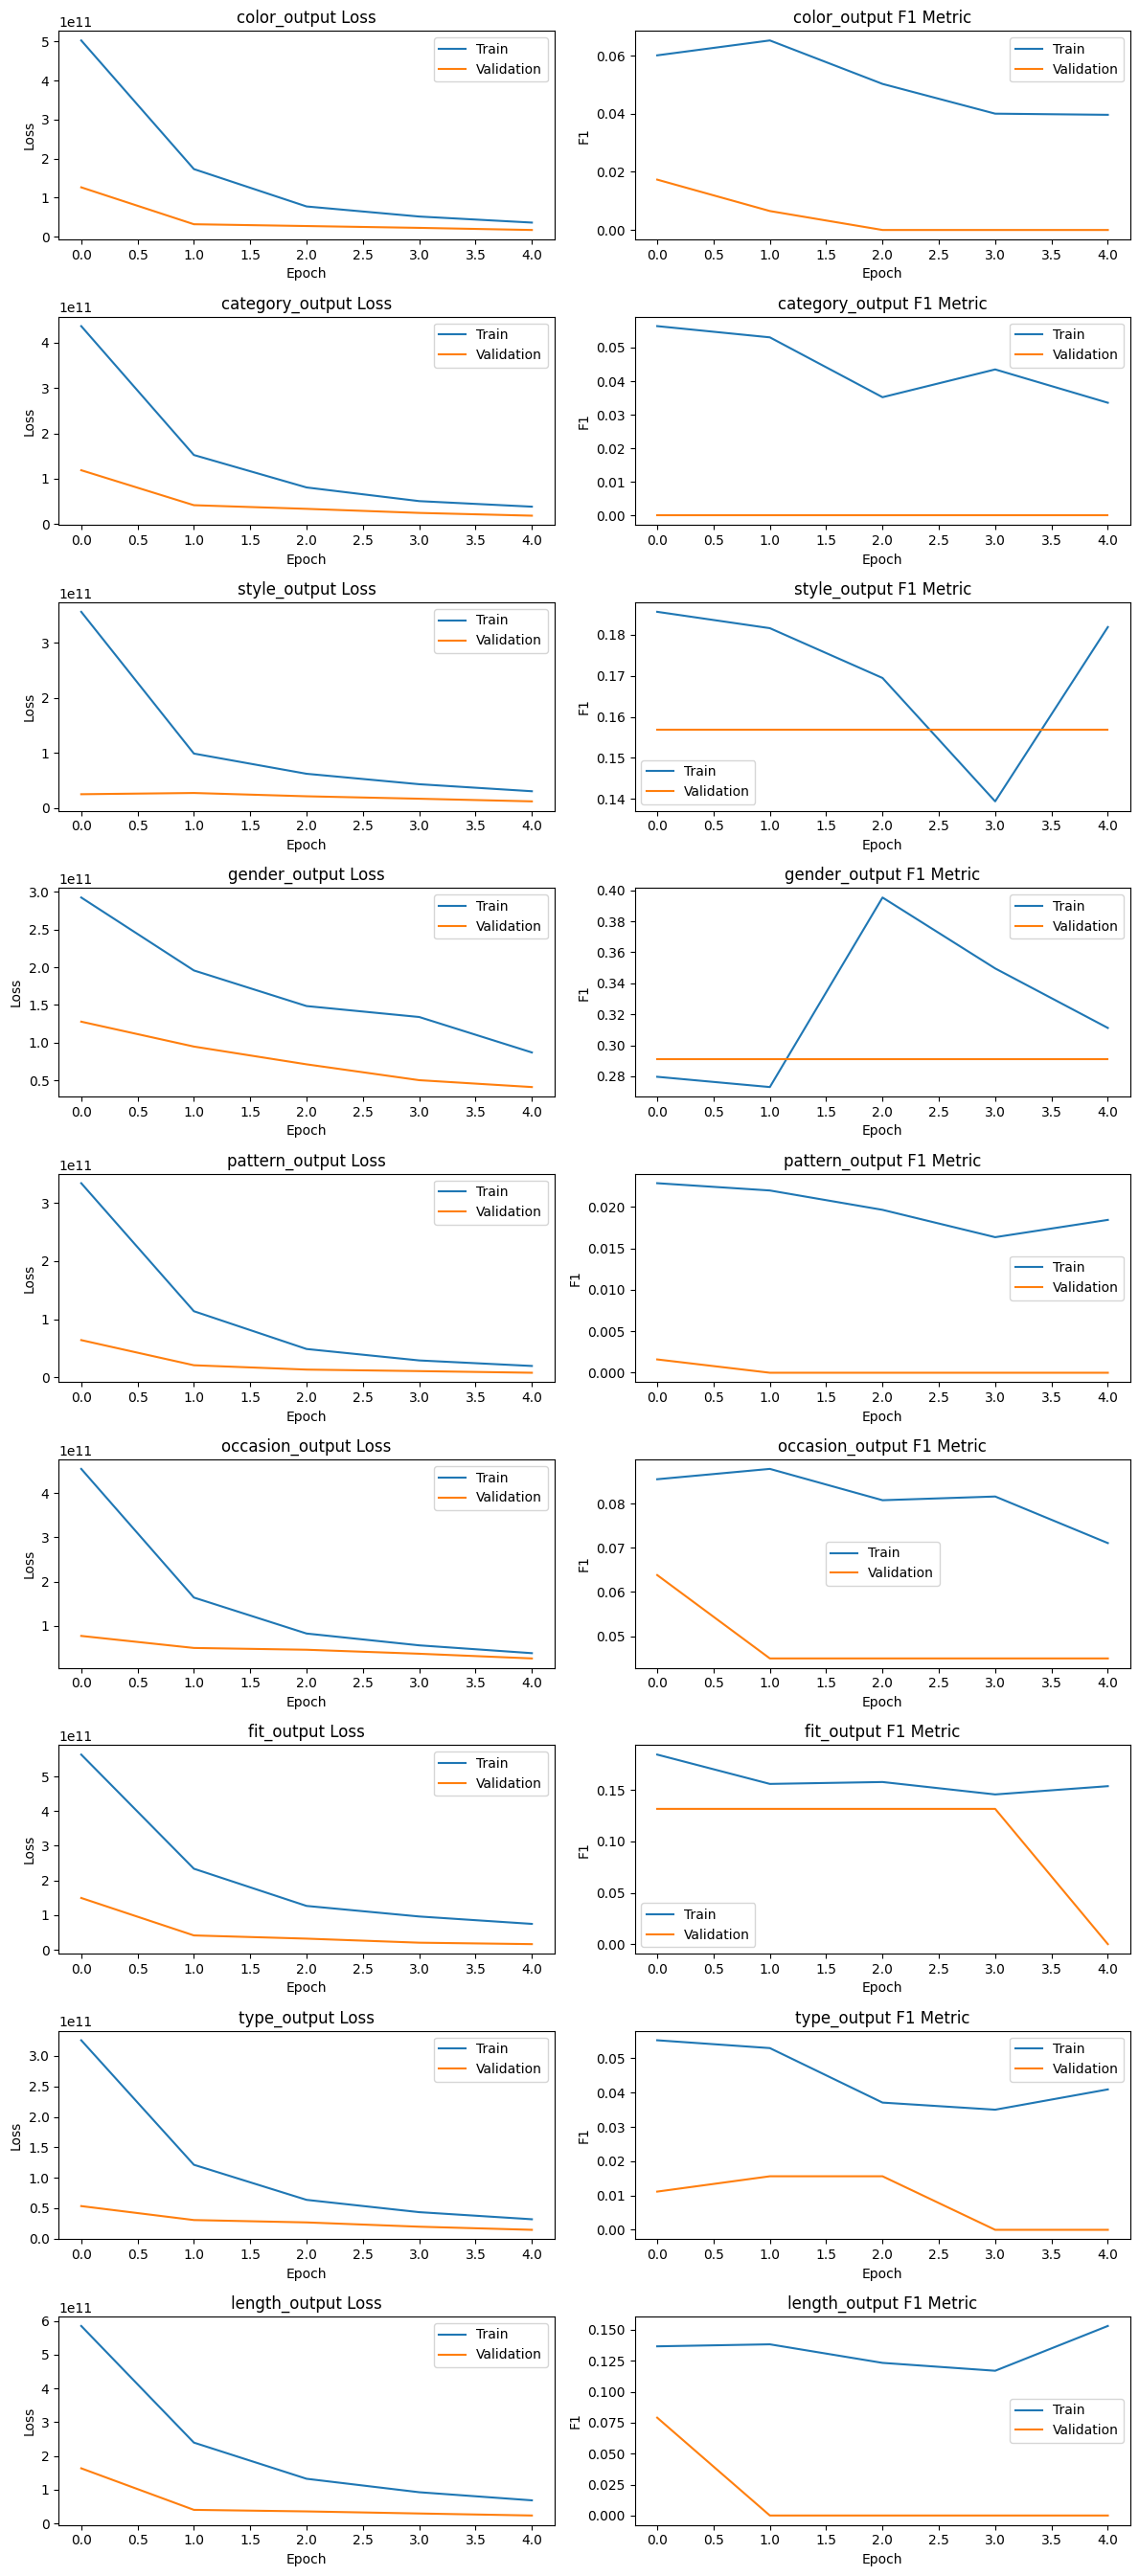

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 116s 5s/step - category_output_f1_metric: 0.0478 - category_output_loss: 31544631296.0000 - color_output_f1_metric: 0.0347 - color_output_loss: 30616582144.0000 - fit_output_f1_metric: 0.1878 - fit_output_loss: 52879360000.0000 - gender_output_f1_metric: 0.3221 - gender_output_loss: 62464229376.0000 - length_output_f1_metric: 0.1151 - length_output_loss: 59501682688.0000 - loss: 336287465472.0000 - occasion_output_f1_metric: 0.0732 - occasion_output_loss: 31068229632.0000 - pattern_output_f1_metric: 0.0168 - pattern_output_loss: 16181586944.0000 - style_output_f1_metric: 0.1636 - style_output_loss: 25731080192.0000 - type_output_f1_metric: 0.0378 - type_output_loss: 26322972672.0000 - val_category_output_f1_metric: 0.0000e+00 - val_category_output_loss: 18394660864.0000 - val_color_output_f1_metric: 0.0000e+00 - val_color_output_loss: 16841054208.0000 - val_fit_output_f1_metric: 0.0000e+00 - val_fit_output_loss: 15799969792.0000 - val_gender_output_

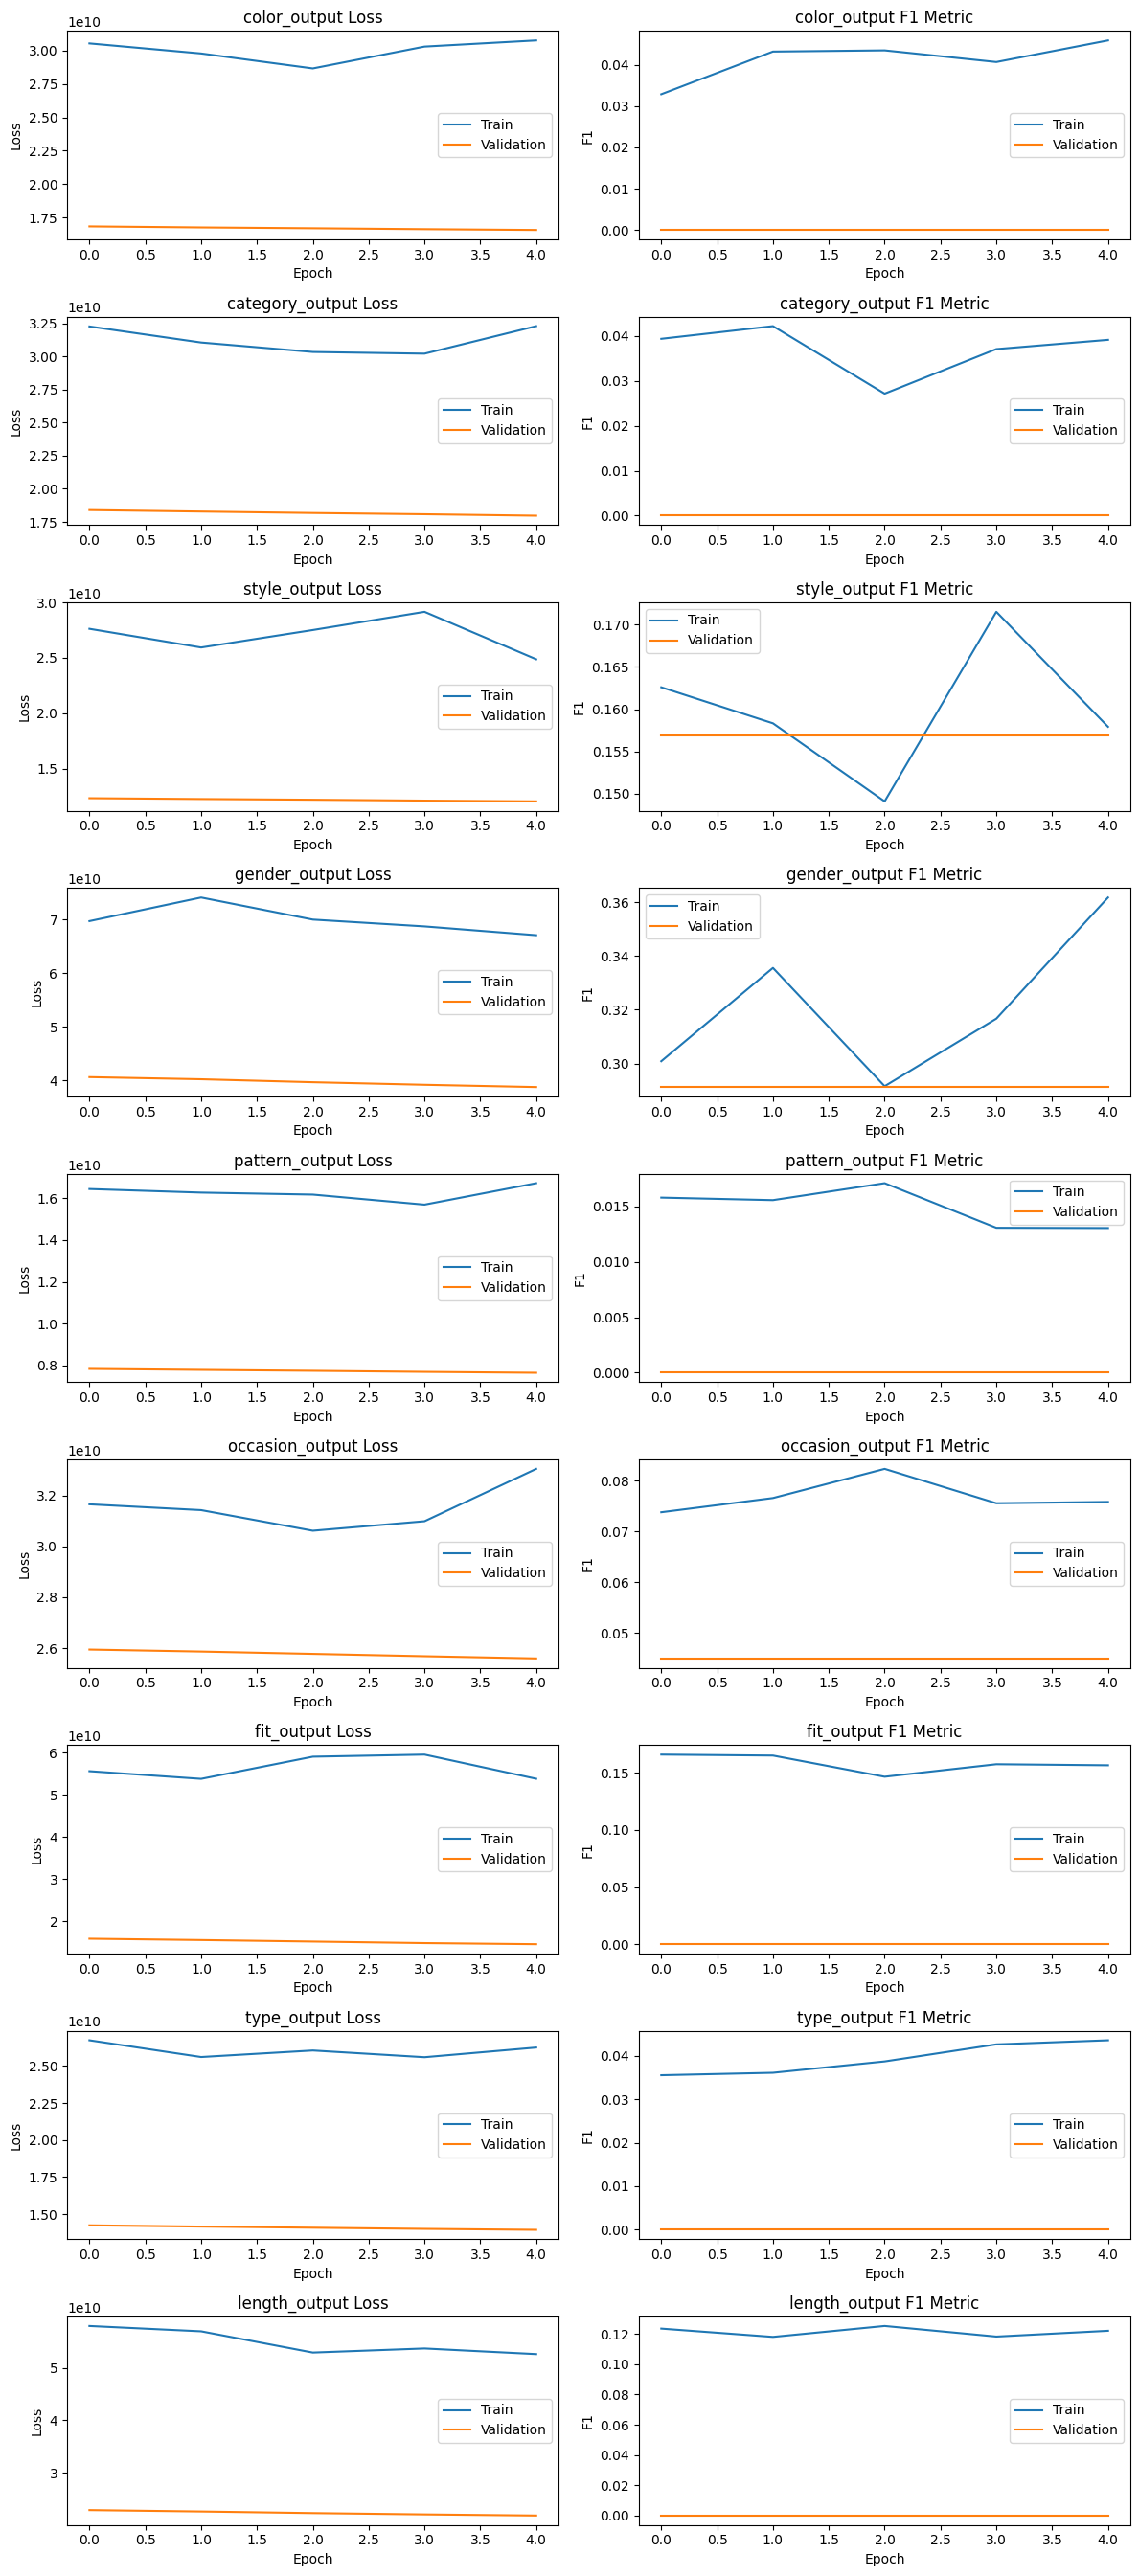

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - category_output_f1_metric: 0.0000e+00 - category_output_loss: 17982750720.0000 - color_output_f1_metric: 0.0000e+00 - color_output_loss: 17029284864.0000 - fit_output_f1_metric: 0.0000e+00 - fit_output_loss: 15581388800.0000 - gender_output_f1_metric: 0.2997 - gender_output_loss: 32470812672.0000 - length_output_f1_metric: 0.0000e+00 - length_output_loss: 23291387904.0000 - loss: 160329105408.0000 - occasion_output_f1_metric: 0.0441 - occasion_output_loss: 23699916800.0000 - pattern_output_f1_metric: 0.0000e+00 - pattern_output_loss: 7809963008.0000 - style_output_f1_metric: 0.1588 - style_output_loss: 9293174784.0000 - type_output_f1_metric: 0.0000e+00 - type_output_loss: 14220054528.0000

Evaluation results: [166253576192.0, 16574332928.0, 17971830784.0, 12039972864.0, 38749847552.0, 7646992896.0, 25595240448.0, 14500244480.0, 13939789824.0, 21859405824.0, 0.0, 0.0, 0.0, 0.29125502705574036, 0.0, 0.0449943020939827, 0.0, 0.15692642331123352, 0.0]

In [14]:
dataset_paths = "Data/dataset_drop_encoded.csv"
model_obj, hist, eval_res = run_pipeline(dataset_paths)